In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 2000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

generating sample 1 of 2000
generating sample 2 of 2000
generating sample 3 of 2000
generating sample 4 of 2000
generating sample 5 of 2000
generating sample 6 of 2000
generating sample 7 of 2000
generating sample 8 of 2000
generating sample 9 of 2000
generating sample 10 of 2000
generating sample 11 of 2000
generating sample 12 of 2000
generating sample 13 of 2000


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


generating sample 14 of 2000
generating sample 15 of 2000
generating sample 16 of 2000
generating sample 17 of 2000
generating sample 18 of 2000
generating sample 19 of 2000
generating sample 20 of 2000
generating sample 21 of 2000
generating sample 22 of 2000
generating sample 23 of 2000
generating sample 24 of 2000
generating sample 25 of 2000
generating sample 26 of 2000
generating sample 27 of 2000
generating sample 28 of 2000
generating sample 29 of 2000
generating sample 30 of 2000
generating sample 31 of 2000
generating sample 32 of 2000
generating sample 33 of 2000
generating sample 34 of 2000
generating sample 35 of 2000
generating sample 36 of 2000
generating sample 37 of 2000
generating sample 38 of 2000
generating sample 39 of 2000
generating sample 40 of 2000
generating sample 41 of 2000
generating sample 42 of 2000
generating sample 43 of 2000
generating sample 44 of 2000
generating sample 45 of 2000
generating sample 46 of 2000
generating sample 47 of 2000
generating sam

generating sample 297 of 2000
generating sample 298 of 2000
generating sample 299 of 2000
generating sample 300 of 2000
generating sample 301 of 2000
generating sample 302 of 2000
generating sample 303 of 2000
generating sample 304 of 2000
generating sample 305 of 2000
generating sample 306 of 2000
generating sample 307 of 2000
generating sample 308 of 2000
generating sample 309 of 2000
generating sample 310 of 2000
generating sample 311 of 2000
generating sample 312 of 2000
generating sample 313 of 2000
generating sample 314 of 2000
generating sample 315 of 2000
generating sample 316 of 2000
generating sample 317 of 2000
generating sample 318 of 2000
generating sample 319 of 2000
generating sample 320 of 2000
generating sample 321 of 2000
generating sample 322 of 2000
generating sample 323 of 2000
generating sample 324 of 2000
generating sample 325 of 2000
generating sample 326 of 2000
generating sample 327 of 2000
generating sample 328 of 2000
generating sample 329 of 2000
generating

generating sample 594 of 2000
generating sample 595 of 2000
generating sample 596 of 2000
generating sample 597 of 2000
generating sample 598 of 2000
generating sample 599 of 2000
generating sample 600 of 2000
generating sample 601 of 2000
generating sample 602 of 2000
generating sample 603 of 2000
generating sample 604 of 2000
generating sample 605 of 2000
generating sample 606 of 2000
generating sample 607 of 2000
generating sample 608 of 2000
generating sample 609 of 2000
generating sample 610 of 2000
generating sample 611 of 2000
generating sample 612 of 2000
generating sample 613 of 2000
generating sample 614 of 2000
generating sample 615 of 2000
generating sample 616 of 2000
generating sample 617 of 2000
generating sample 618 of 2000
generating sample 619 of 2000
generating sample 620 of 2000
generating sample 621 of 2000
generating sample 622 of 2000
generating sample 623 of 2000
generating sample 624 of 2000
generating sample 625 of 2000
generating sample 626 of 2000
generating

generating sample 886 of 2000
generating sample 887 of 2000
generating sample 888 of 2000
generating sample 889 of 2000
generating sample 890 of 2000
generating sample 891 of 2000
generating sample 892 of 2000
generating sample 893 of 2000
generating sample 894 of 2000
generating sample 895 of 2000
generating sample 896 of 2000
generating sample 897 of 2000
generating sample 898 of 2000
generating sample 899 of 2000
generating sample 900 of 2000
generating sample 901 of 2000
generating sample 902 of 2000
generating sample 903 of 2000
generating sample 904 of 2000
generating sample 905 of 2000
generating sample 906 of 2000
generating sample 907 of 2000
generating sample 908 of 2000
generating sample 909 of 2000
generating sample 910 of 2000
generating sample 911 of 2000
generating sample 912 of 2000
generating sample 913 of 2000
generating sample 914 of 2000
generating sample 915 of 2000
generating sample 916 of 2000
generating sample 917 of 2000
generating sample 918 of 2000
generating

generating sample 1161 of 2000
generating sample 1162 of 2000
generating sample 1163 of 2000
generating sample 1164 of 2000
generating sample 1165 of 2000
generating sample 1166 of 2000
generating sample 1167 of 2000
generating sample 1168 of 2000
generating sample 1169 of 2000
generating sample 1170 of 2000
generating sample 1171 of 2000
generating sample 1172 of 2000
generating sample 1173 of 2000
generating sample 1174 of 2000
generating sample 1175 of 2000
generating sample 1176 of 2000
generating sample 1177 of 2000
generating sample 1178 of 2000
generating sample 1179 of 2000
generating sample 1180 of 2000
generating sample 1181 of 2000
generating sample 1182 of 2000
generating sample 1183 of 2000
generating sample 1184 of 2000
generating sample 1185 of 2000
generating sample 1186 of 2000
generating sample 1187 of 2000
generating sample 1188 of 2000
generating sample 1189 of 2000
generating sample 1190 of 2000
generating sample 1191 of 2000
generating sample 1192 of 2000
generati

generating sample 1434 of 2000
generating sample 1435 of 2000
generating sample 1436 of 2000
generating sample 1437 of 2000
generating sample 1438 of 2000
generating sample 1439 of 2000
generating sample 1440 of 2000
generating sample 1441 of 2000
generating sample 1442 of 2000
generating sample 1443 of 2000
generating sample 1444 of 2000
generating sample 1445 of 2000
generating sample 1446 of 2000
generating sample 1447 of 2000
generating sample 1448 of 2000
generating sample 1449 of 2000
generating sample 1450 of 2000
generating sample 1451 of 2000
generating sample 1452 of 2000
generating sample 1453 of 2000
generating sample 1454 of 2000
generating sample 1455 of 2000
generating sample 1456 of 2000
generating sample 1457 of 2000
generating sample 1458 of 2000
generating sample 1459 of 2000
generating sample 1460 of 2000
generating sample 1461 of 2000
generating sample 1462 of 2000
generating sample 1463 of 2000
generating sample 1464 of 2000
generating sample 1465 of 2000
generati

generating sample 1700 of 2000
generating sample 1701 of 2000
generating sample 1702 of 2000
generating sample 1703 of 2000
generating sample 1704 of 2000
generating sample 1705 of 2000
generating sample 1706 of 2000
generating sample 1707 of 2000
generating sample 1708 of 2000
generating sample 1709 of 2000
generating sample 1710 of 2000
generating sample 1711 of 2000
generating sample 1712 of 2000
generating sample 1713 of 2000
generating sample 1714 of 2000
generating sample 1715 of 2000
generating sample 1716 of 2000
generating sample 1717 of 2000
generating sample 1718 of 2000
generating sample 1719 of 2000
generating sample 1720 of 2000
generating sample 1721 of 2000
generating sample 1722 of 2000
generating sample 1723 of 2000
generating sample 1724 of 2000
generating sample 1725 of 2000
generating sample 1726 of 2000
generating sample 1727 of 2000
generating sample 1728 of 2000
generating sample 1729 of 2000
generating sample 1730 of 2000
generating sample 1731 of 2000
generati

generating sample 1983 of 2000
generating sample 1984 of 2000
generating sample 1985 of 2000
generating sample 1986 of 2000
generating sample 1987 of 2000
generating sample 1988 of 2000
generating sample 1989 of 2000
generating sample 1990 of 2000
generating sample 1991 of 2000
generating sample 1992 of 2000
generating sample 1993 of 2000
generating sample 1994 of 2000
generating sample 1995 of 2000
generating sample 1996 of 2000
generating sample 1997 of 2000
generating sample 1998 of 2000
generating sample 1999 of 2000
generating sample 2000 of 2000


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery

img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [10]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(1600, 1800)

In [11]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform) # will return RGB by default
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform)
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [12]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [13]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [14]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

In [15]:
import time

### call outside training method, in loop

# iterate over some batch sizes
times = []
batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
for bsize in batch_sizes:
    model = unet11(pretrained=False)
    
    # set some parameters
    lr = 0.001
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = LossBinary(jaccard_weight=args.jaccard_weight)
    #criterion = nn.BCELoss()

    # make model parallel and on GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
        model.to(device)
    
    print('batchsize, ', bsize)
    mean_loss = 0.0
    running_loss = 0.0
    print('training...')

    losses=[]
    losses_ep = []
    #tl = zip(dg_dl_train, gt_dl_train)
    step=0


    ###### specify DataLoaders
    ## GT
    gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
    gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


    ## DG
    dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
    dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


    # record time for one epoch
    t0 = time.time()
    for i in range(1):
        epoch = i+1
        print('on epoch {}'.format(epoch))
        tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
        for i, (inputs_, targets_) in enumerate(tl):

            # get the inputs
            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = variable(inputs_), variable(targets_)
            inputs.to(device)
            targets.to(device)
            
            outputs = model(inputs)
            
            # zero parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = criterion(outputs, targets)                
            i_loss.backward()
            optimizer.step()
            step+=1

            # print statistics
    #         print("Outside: input size", inputs.size(),
    #           "output_size", outputs.size())

            if i%10 == 0: # print/store every 10
                losses.append(i_loss)
    #             running_loss += i_loss
    #             print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        losses_ep.append(losses)

    t1 = time.time()
    print (t1 - t0)
    times.append(t1-t0)

Let's use 4 GPUs!
batchsize,  50
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


288.6308443546295
Let's use 4 GPUs!
batchsize,  100
training...
on epoch 1


KeyboardInterrupt: 

In [16]:
inputs.is_cuda, targets.is_cuda

(True, True)

In [29]:
### call outside training method, in loop

model = unet11(pretrained=False).cuda()

# make model parallel!
if torch.cuda.device_count() > 50:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

# set some parameters
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)

mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0

t0 = time.time()
for i in range(1):
    epoch = i+1
    print('on epoch {}'.format(epoch))
    tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
    for i, (inputs, targets) in enumerate(tl):

        # get the inputs
        inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()
        step+=1

        # print statistics
#         print("Outside: input size", inputs.size(),
#           "output_size", outputs.size())
        
#         if i%10 == 0: # print/store every 10
#             losses.append(i_loss)
#             running_loss += i_loss
#             print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))
            
    losses_ep.append(losses)
    
t1 = time.time()
print (t1 - t0)

training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


518.8837652206421


570.0541000366211

('Wed Aug  1 19:56:58 2018', 'Wed Aug  1 19:47:28 2018')

In [25]:
model_path = 'runs/debug/model_44epochs_no_aug.pt'        
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

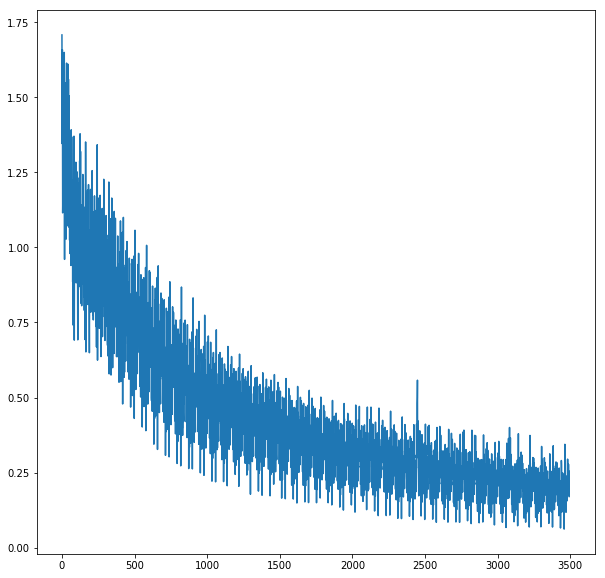

In [34]:
# plot the losses
plt.plot([l.data.cpu().numpy() for l in losses])

In [33]:
losses[0].data.cpu().numpy()

array(1.7075841, dtype=float32)

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


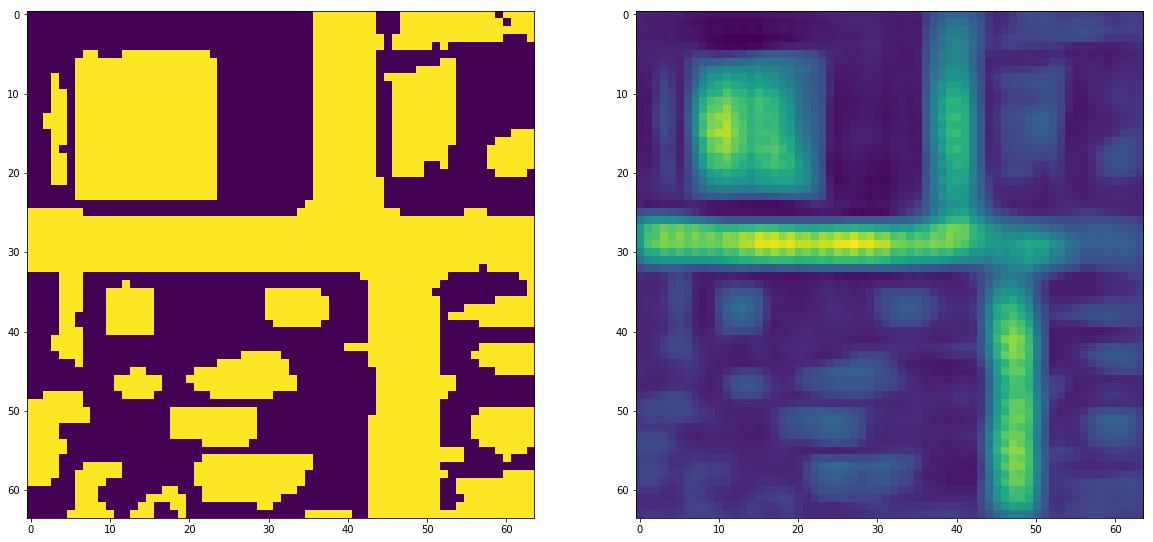

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


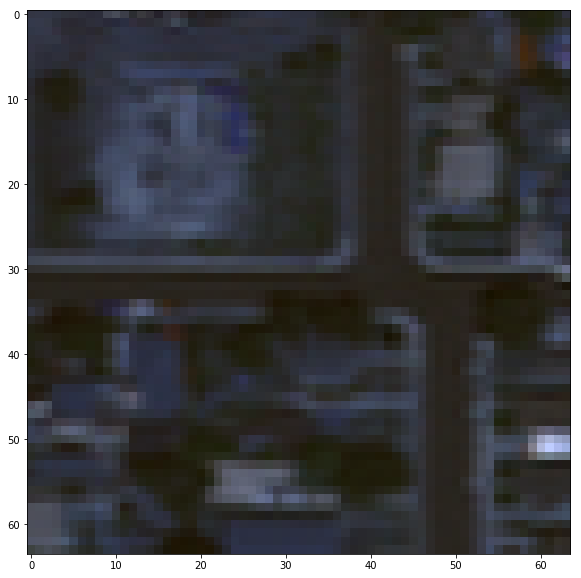

In [35]:
# check one of the test images
test_ind = 100
input_img = torch.unsqueeze(variable(dg_dataset_val[test_ind], volatile=True), dim=0) 
mask = model(input_img)


mask_im = mask.squeeze().data.cpu().numpy()
mask_binary = mask_im.copy()

fig, ax = plt.subplots(1,2, figsize=(20,10))
thresh = 0
mask_binary[mask_im<=thresh] = 0
mask_binary[mask_im>thresh] = 1
ax[0].imshow(mask_binary)
# ax[0].colorbar()
gt_im = gt_dataset_val[test_ind].numpy().squeeze()
ax[1].imshow(mask_im)
# ax[1].colorbar()
plt.show()

source_im = dg_dataset_val[test_ind].numpy()
plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
plt.show()



In [36]:
# save current state
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

root = Path('runs/debug')
model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
ep=epoch
step=i

save(ep)

In [ ]:
#load model
if model_path.exists():
    state = torch.load(str(model_path))
    epoch = state['epoch']
    step = state['step']
    model.load_state_dict(state['model'])
    print('Restored model, epoch {}, step {:,}'.format(epoch, step))